# Assignment 1
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

## Setup Notebook
Import libraries that will be used for the completion of both questions and define utility functions used for completing both Questions.

In [1]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from numba import njit, prange
import numexpr as ne
# Test Flag: Decides if the tests used to ensure the
# code is running properly are run. Set to False for Submission.
TESTING_ACTIVE = True

def test(func):
    """
    Decorator that will run the given test function only
    if the global boolean flag TESTING_ACTIVE is set to
    True.
    
    Example: 
    ```
    def add(a, b):
        return a + b

    @test
    def test_add():
        assert(
            add(1, 2) == 3
        )
    ```
    """
    if TESTING_ACTIVE:
        func()

## Question 1: Random Walk on a Lattice
Objectives:
* Compute the probability that the particle reaches the bottom edge of the latice for each point on the lattice
* Study the convergence of the code as you increase the number of walk trials per lattice point, and as you increase the number N of lattice points
* Optimise runtime of code and justify decisions

Standards:
* 0 is North, 1 is East, 2 is South, 3 is West
* Moving North decreases position, moving East increases position
* Lattitudal movement is index 0, Latteral movement is index 1

### Non-Optimised Problem Implementation
In a first instance, the code to calculate the probabilites is implemented with no attention to performance. This will be used to check the correctness of the optimised verion of the code and as a benchmark for performance improvements.

In [2]:
NORTH = 0
EAST = 1
SOUTH = 2
WEST = 3


def step(particle, direction):
    """
    Return the new position of the particle.
    """
    # Unpack the position of the particle
    lon = particle[0]
    lat = particle[1]
    if direction == NORTH:
        return [lon-1, lat]
    if direction == EAST:
        return [lon, lat+1]
    if direction == SOUTH:
        return [lon+1, lat]
    if direction == WEST:
        return [lon, lat-1]
    raise Exception('Unknown direction given' + str(direction))


def random_step(particle):
    """
    Execute the ```walk``` function with in a random
    direction
    """
    # Get a random direction (i.e number 0 to 3 inc.)
    direction = randint(4)
    return step(particle, direction)


def create_lattice(height, width):
    """
    Return a vector indicating the maximum height index
    (position 0) and maximum width index allowed
    (position 1)
    """
    if width < 1 or height < 1:
        raise Exception('Lattice is zero-sized')
    return [height-1, width-1]


def on_border(particle, lattice):
    """
    Returns a integer indicating if the particle is still
    in the middle of the lattice (0), on a non-bottom
    edge (1), or on the bottom edge (2)
    """
    # Is particle on the North edge
    on_north = particle[0] <= 0
    # Is particle on the West edge
    on_west = particle[1] <= 0
    # Is paricle on the East edge
    on_east = particle[1] >= lattice[1]
    # Is particle on the South edge
    on_south = particle[0] >= lattice[0]
    if on_south:
        return 2
    elif on_north or on_west or on_east:
        return 1
    else:
        return 0


def create_particle(lon, lat):
    """
    Place the particle on a random location on the lattice.
    """
    return [lon, lat]


def random_walk(particle, lattice):
    """
    Run a random walk simulation. Return True if the
    particle finishes on the bottom edge, False if it
    finishes on any other edge.
    """
    while not on_border(particle, lattice):
        particle = random_step(particle)
    return on_border(particle, lattice)-1 # convert 1-2 scale to 0-1


@test
def integration():
    """
    Check all the functions run with each other and that the final
    result is the correct format.
    """
    lattice = create_lattice(5, 5)
    particle = create_particle(2, 2)
    result = random_walk(particle, lattice)
    assert(result == 0 or result == 1)
    
    lattice = create_lattice(5, 5)
    particle = create_particle(4, 4)
    result = random_walk(particle, lattice)
    assert(result == 1)

    
def measure_success(particle, lattice, iterations):
    """
    Measure the success rate of particle reaching the bottom
    point for a set number of iterations
    """
    successes = 0
    for _ in range(int(iterations)):
        successes += random_walk(particle, lattice)
    return successes/iterations


def list_lattice_points(lattice):
    """
    Produce a list of all the lattice points possible.
    """
    lat_points = [i for i in range(lattice[1]+1)]
    lon_points = [i for i in range(lattice[0]+1)]
    return list(product(lon_points, lat_points))


def calculate_probability_grid(height, width, iterations):
    """
    Run the experiment, measuring success rates for a particle
    starting on each point of a lattice of the given size.
    """
    lattice = create_lattice(height, width)
    results = np.empty((height, width))
    for lon, lat in list_lattice_points(lattice):
        particle = create_particle(lon, lat)
        success = measure_success(particle, lattice, iterations)
        results[lon, lat] = measure_success(particle, lattice, iterations)
    return results


def show_success_map(results_matrix):
    """
    Creates a heatmap of the results.
    """
    plt.imshow(results_matrix, cmap='hot', interpolation='nearest')
    plt.show()

In [3]:
# @test
# def run_linear():
#     success_map = calculate_probability_grid(10, 10, 100)
#     show_success_map(success_map)

In [4]:
# %timeit calculate_probability_grid(10, 10, 100)

### Performance-Optimised Implementation
In this next section, we reimplement the problem while optimising the alogrithm's executing time. This will be done by using a combination of Numba's JIT compilation methods, Multiprocessing's multicore calculation capabilities and Numexpr's vector addtion functions.

While Numexpr has multicore abilities when Intel's MLK is installed, this is not guaranteed to be the case on every machine. For this reason, this implmentation relies on Multiprocessing instead to divide the work among the available CPU cores.

In [6]:
@njit(['float64[:,:](int64, int64)'])
def initialise_starting_points(width, height):
    """
    """
    number_of_points = height*width
    indexes = np.arange(number_of_points)
    starting_points = np.empty((number_of_points, 2))
    starting_points[:, 0] = indexes%width
    starting_points[:, 1] = indexes//width
    return starting_points


@njit(['float64[:,:](int64)'])
def generate_random_steps(number_of_points):
    """
    """
    steps = np.zeros((number_of_points, 2))
    output = np.empty_like(steps)
    directions = np.random.randint(0, 4, (number_of_points))
    steps[:, 0] = np.cos(directions/4*2*np.pi)
    steps[:, 1] = np.sin(directions/4*2*np.pi)
    np.round(steps, 1, output)
    return output
    

@njit(['float64[:,:](float64[:,:], float64[:,:])'])
def step(particles, steps):
    """
    """
    return particles+steps
    
    

@njit(['float64[:,:](float64[:,:])'])
def step_randomly(particles):
    """
    """
    number_of_points = len(particles)
    steps = generate_random_steps(number_of_points)
    return step(particles, steps)


@njit(['float64[:](float64[:,:], int64, int64)'])
def get_states(particles, width, height):
    """
    """
    states = np.zeros((width*height, 1))
    actual_width = particles[:, 0]
    actual_height = particles[:, 1]
    on_south = actual_height >= (height-1)
    on_north = actual_height <= 0
    on_east = actual_width >= (width-1) 
    on_west = actual_width <= 0 
    states[on_north | on_east | on_west] = 1
    states[on_south] = 2
    return states.flatten()


@njit(['float64[:,:](float64[:,:], int64, int64)'])
def random_walk(particles, width, height):
    """
    """
    states = get_states(particles, width, height)
    while particles[states == 0].size > 0:
        particles[states == 0] = step_randomly(particles[states == 0])
        states = get_states(particles, width, height)
    return particles

@njit(['float64[:](float64[:,:], int64, int64)'])
def get_success(particles, width, height):
    """
    """
    states = get_states(particles, width, height)
    successes = states >= 2
    return successes*1.0


@njit(['float64[:,:](int64, int64)'], parallel=True)
def measure_success(iterations, size):
    """
    """
    width = size
    height = size
    results = np.zeros((width*height,), dtype=np.double)
    for _ in prange(iterations):
        particles = initialise_starting_points(width, height)
        particles = random_walk(particles, width, height)
        results += get_success(particles, width, height)
    results = results.reshape(width, height)/iterations
    return results

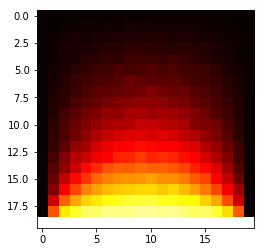

In [7]:
results = measure_success(2000, 20)
show_success_map(results)

In [8]:
%timeit results = measure_success(100, 10)

15.9 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Question 2: Potentials Generated by Random Particles
Objectives:
* Implement an efficient method to compute and visualise f(r) for 1 < r < 10
* Estimate the expected relative error (via random placemtns of particles
* Describe your code implementation strategy, optimisations, and the influence of the parameters N, M and number of random trials

### Linear Code
Implementation of the problem without parallelisation

In [9]:
def potential(x, y):
    """
    Calculate the potential of point y at point x.
    """
    pi = np.pi
    distance = np.linalg.norm(x - y, axis=1)
    potential = ne.evaluate('sum(1/(2*pi)*log(distance))')
    return potential


def get_measurment_points(radius, M):
    """
    Create M equally spaced points on a circle of the given
    radius
    """
    points = np.empty((M, 2))
    points[:, 0] = np.array([i/M*2*np.pi for i in range(M)])
    points[:, 1] = radius
    return radial_to_cartesian(points)
    

def num_combined_potential(radius, M, y):
    """
    Calculate the averaged potential of all points y
    within a circle of given radius on M circumfrence
    points, equally spaced.
    """
    x = get_measurment_points(radius, M)
    average_potential = sum([
        potential(x[i, :], y) for i in range(M)
    ])/(len(y)*M)
    return average_potential


def radial_to_cartesian(radial):
    """
    Transform a set of points in radial coordinates
    into the equivalent points in cartesian coordinates
    """
    cartesian = np.empty_like(radial)
    cartesian[:, 0] = radial[:, 1]*np.cos(radial[:, 0])
    cartesian[:, 1] = radial[:, 1]*np.sin(radial[:, 0])
    return cartesian


def spawn_y(N):
    """
    Creates N random 2-D points in a unit circle,
    unifromly distributed. [See Reference 1]
    """
    N = int(N)
    relative_points = np.random.rand(N, 2)
    relative_points[:, 0] = 2*np.pi*relative_points[:, 0]
    relative_points[:, 1] = np.sqrt(relative_points[:, 1])
    return radial_to_cartesian(relative_points)


def show_particles(y, x=None):
    """
    Show a scatter plot of the points y.
    """
    plt.scatter(y[:, 0], y[:, 1])
    if type(x) != None:
        plt.scatter(x[:, 0], x[:, 1])
    plt.show()


def single_centre_potential(radius):
    """
    Calculate the uniform potential of a particle at the centre
    of a circle of the given radius on a point on the
    circumfrence.
    """
    return np.log(radius)/(2*np.pi)


def r_linspace(low, high, R):
    """
    Create R linearly spaced points between low and high.
    """
    return np.linspace(low, high, R)


def calculate_multi_radii(low, high, R, M, y):
    """
    Calculate the average potential for N points evenly
    spaced in the range (low, high) - non inclusive """
    radii = r_linspace(low, high, R)
    return np.array([
        num_combined_potential(radius, M, y) 
        for radius in radii
    ]).reshape(R, 1)


def single_centre_multi_radii(low, high, R):
    """
    Calculates the single centre potential for multiple
    radii.
    """
    radii = r_linspace(low, high, R)
    return np.array([
        single_centre_potential(radius)
        for radius in radii
    ]).reshape(R, 1)
    

def relative_error(centre_point_values, aggregate_values):
    """
    Calculate the relative error for each set of points
    """
    difference = np.linalg.norm(
        centre_point_values - aggregate_values, axis=0
    )
    return np.divide(difference, centre_point_values)


def plot_potential(low, high, R, M, y, show=True):
    """
    Plot the potential
    """
    r = r_linspace(low, high, R)
    potentials = calculate_multi_radii(low, high, R, M, y)
    plt.plot(r, potentials)
    if show:
        plt.show()



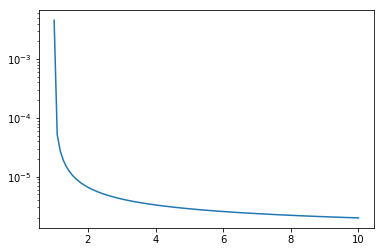

In [67]:
y = spawn_y(1e2)
low = 1.001
high = 10
R = 100
M = 100

r = r_linspace(low, high, R)
exact = single_centre_multi_radii(low, high, R)
exper_s = calculate_multi_radii(low, high, R, M, y)
Es = relative_error(exact, exper_s)
plt.semilogy(r, Es)
plt.show()

### Performance-Optimised Code
Implementation of the problem without parallelisation

In [82]:
# #@njit(['float64[:,:](int64, int64, int64, int64)'])
# def create_reference_grid(low, high, R, M):
#     """
#     """
#     number_of_points = R*M
#     indexes = np.arange(number_of_points)
#     reference = np.empty((number_of_points, 2))
#     if R > M:
#         mod = R
#     else:
#         mod = M
#     reference[:, 0] = indexes//mod
#     reference[:, 1] = indexes%mod
#     return reference


# #@njit
# def numba_get_measurement_points(low, high, R, M):
#     """
#     radius then angle
#     """
#     reference = create_reference_grid(low, high, R, M)
#     measurement_points = np.empty_like(reference)
#     measurement_points[:, 0] = reference[:, 0]/M*2*np.pi
#     measurement_points[:, 1] = reference[:, 1]*(high-low)/R + low
#     return numba_radial_to_cartesian(measurement_points)
    

# #@njit
# def numba_radial_to_cartesian(radial):
#     """
#     Transform a set of points in radial coordinates
#     into the equivalent points in cartesian coordinates
#     """
#     cartesian = np.empty_like(radial)
#     cartesian[:, 0] = radial[:, 1]*np.cos(radial[:, 0])
#     cartesian[:, 1] = radial[:, 1]*np.sin(radial[:, 0])
#     return cartesian


# #@njit
# def numba_potential(x, y, N, M):
#     """
#     """
#     distances = np.sqrt((x[0] - y[:, 0])**2 + (x[1] - y[:, 1])**2)
# #     print(distances)
#     potentials = 1/(2*np.pi)*np.log(distances)
# #     print(potentials)
#     potential = np.sum(potentials)/N
# #     print(potential)
#     return potential


# #@njit(['float64[:,:](int64)'])
# def numba_spawn_y(N):
#     """
#     Creates N random 2-D points in a unit circle,
#     unifromly distributed. [See Reference 1]
#     """
#     N = int(N)
#     relative_points = np.random.rand(N, 2)
#     relative_points[:, 1] = np.sqrt(relative_points[:, 1])
#     relative_points[:, 0] = relative_points[:, 0]*2*np.pi
#     return numba_radial_to_cartesian(relative_points)


# #@njit
# def averaged_error_curve(low, high, R, M, N, iterations):
#     """
#     Calculate an averaged error curve.
#     """
#     number_of_points = R*M
#     measurement_points = numba_get_measurement_points(low, high, R, M)
#     m_potential = np.zeros((number_of_points, iterations))
#     for j in prange(iterations): # for many y
#         y = numba_spawn_y(N)
#         for i in prange(number_of_points):
#             m_potential[i, j] = numba_potential(measurement_points[i, :], y, N, M)
#     avg_potential_for_points = np.sum(m_potential, axis=1)/iterations
# #     return avg_potential_for_points
# #     print(avg_potential_for_points)
#     avg_potential = np.sum(avg_potential_for_points.reshape(M, R), axis=0)/M
#     return avg_potential.reshape(R, 1)

def potential(x, y):
    """
    Calculate the potential of point y at point x.
    """
    pi = np.pi
    distance = np.linalg.norm(x - y, axis=1)
    potential = ne.evaluate('sum(1/(2*pi)*log(distance))')
    return potential


def get_measurment_points(radius, M):
    """
    Create M equally spaced points on a circle of the given
    radius
    """
    points = np.empty((M, 2))
    points[:, 0] = np.array([i/M*2*np.pi for i in range(M)])
    points[:, 1] = radius
    return radial_to_cartesian(points)
    

def num_combined_potential(radius, M, y):
    """
    Calculate the averaged potential of all points y
    within a circle of given radius on M circumfrence
    points, equally spaced.
    """
    x = get_measurment_points(radius, M)
    average_potential = sum([
        potential(x[i, :], y) for i in range(M)
    ])/(len(y)*M)
    return average_potential


def radial_to_cartesian(radial):
    """
    Transform a set of points in radial coordinates
    into the equivalent points in cartesian coordinates
    """
    cartesian = np.empty_like(radial)
    cartesian[:, 0] = radial[:, 1]*np.cos(radial[:, 0])
    cartesian[:, 1] = radial[:, 1]*np.sin(radial[:, 0])
    return cartesian


def spawn_y(N):
    """
    Creates N random 2-D points in a unit circle,
    unifromly distributed. [See Reference 1]
    """
    N = int(N)
    relative_points = np.random.rand(N, 2)
    relative_points[:, 0] = 2*np.pi*relative_points[:, 0]
    relative_points[:, 1] = np.sqrt(relative_points[:, 1])
    return radial_to_cartesian(relative_points)


def show_particles(y, x=None):
    """
    Show a scatter plot of the points y.
    """
    plt.scatter(y[:, 0], y[:, 1])
    if type(x) != None:
        plt.scatter(x[:, 0], x[:, 1])
    plt.show()


def single_centre_potential(radius):
    """
    Calculate the uniform potential of a particle at the centre
    of a circle of the given radius on a point on the
    circumfrence.
    """
    return np.log(radius)/(2*np.pi)


def r_linspace(low, high, R):
    """
    Create R linearly spaced points between low and high.
    """
    return np.linspace(low, high, R)


def fast_calculate_multi_radii(low, high, R, M, y, iterations):
    """
    Calculate the average potential for N points evenly
    spaced in the range (low, high) - non inclusive """
    radii = r_linspace(low, high, R)
    return np.array([
        num_combined_potential(radius, M, y) 
        for radius in radii
    ]).reshape(R, 1)


In [86]:
N = int(1e2)
low = 1.001
high = 10
R = 10
M = 10
iterations = 100
exact = single_centre_multi_radii(low, high, R)
exper = calculate_multi_radii(low, high, R, M, N)
Ef = relative_error(exact, exper)
r = r_linspace(low, high, R)
plt.semilogy(r, Ef)
plt.semilogy(r, Es)
plt.show()
plt.plot(r, exper)
plt.plot(r, exact)
plt.show()
exper

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
exact

In [146]:
create_reference_grid(low, high, R, M)

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [0., 3.],
       [0., 4.],
       [0., 5.],
       [0., 6.],
       [0., 7.],
       [0., 8.],
       [0., 9.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.],
       [2., 0.],
       [2., 1.],
       [2., 2.],
       [2., 3.],
       [2., 4.],
       [2., 5.],
       [2., 6.],
       [2., 7.],
       [2., 8.],
       [2., 9.]])

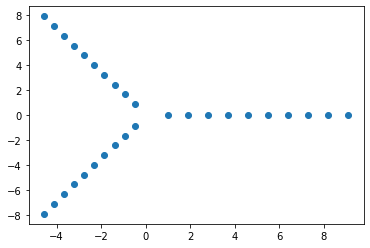

In [112]:
m = numba_get_measurement_points(low, high, R, M)
plt.scatter(m[:, 0], m[:, 1])

# References

[1] https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409#50746409
